#### Introdcution
The BDNF(Brain-Derived Neurotrophic Factor) levels was measureed by using Elisa test kit(LSBio). In this experiment,the whole blood was withdrawn from five healthy controls by using infusion kits and syringe. After collection of the whole blood, we allow the blood to clot by leaving it undisturbed at room temperature around 15-30 minutes. Remove the clot by centrifuging at 1,000-2,000 x g for 10 minutes in a refrigerated centrifuge.

The purpose of this analysis to check whether or not the elisa method can acquire the subject's BDNF level.

In [91]:
"""
Created on Tuesday 8 Nov 2022
Author: ZMW
"""
#import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statistics
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy.random as npr
from scipy.optimize import leastsq
import warnings
warnings.filterwarnings('ignore')

In [92]:
#data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/bdnf_second_batch.xlsx' # read raw data
data_path = os.path.join(dirname,data_file)

In [93]:
#Load the fitted dataset
data = pd.read_excel(data_path)
data = data.iloc[9:17,1:5]#slice rows and columns where data exist
#data = data.loc[:,~data.columns.str.contains('Unnamed')]
data.columns = ['STD_1','Sample_5_fold','Sample_10_fold','STD_2']
data = data.reset_index(drop=True)


#### Plate layout

|  Standard | Sample | Sample | Standard |
|---|---|---|---|
|  SD1 | S1_5 | S1_10 | SD1  |  
|  SD2 |  S1_5 | S1_10 | SD2  | 
|  SD3 | S2_5 |  S2_10 | SD3  | 
|  SD4 |  S2_5|  S2_10 |  SD4 | 
|  SD5 |  S3_5 |   S3_10|   SD5|  
|  SD6 |   S3_5|  S3_10 |  SD6 |  
|  SD7 |  S4_5|  S4_10 | SD7 | 
|  blank |  S4_5|   S4_10| blank | 

### Raw

In [94]:
data

,STD_1,Sample_5_fold,Sample_10_fold,STD_2
0,3.3274,3.2782,2.6732,3.3108
1,2.4362,2.9916,2.3199,2.4685
2,1.4982,3.6362,3.1804,1.5466
3,0.7041,3.4072,3.2547,0.7138
4,0.3405,3.7063,3.0675,0.3699
5,0.1979,3.5763,2.7122,0.2018
6,0.1186,2.8809,2.731,0.1386
7,0.0347,2.885,2.88,0.0348


### Average concentration

In [95]:
# Standard
STD1 = statistics.mean([data.iloc[0,0],data.iloc[0,3]])
STD2 = statistics.mean([data.iloc[1,0],data.iloc[1,3]])
STD3 = statistics.mean([data.iloc[2,0],data.iloc[2,3]])
STD4 = statistics.mean([data.iloc[3,0],data.iloc[3,3]])
STD5 = statistics.mean([data.iloc[4,0],data.iloc[4,3]])
STD6= statistics.mean([data.iloc[5,0],data.iloc[5,3]])
STD7 = statistics.mean([data.iloc[6,0],data.iloc[6,3]])
STD8 = statistics.mean([data.iloc[7,0],data.iloc[7,3]])

# Unknown samples
S1_5 = statistics.mean([data.iloc[0,1],data.iloc[1,1]])
S2_5 = statistics.mean([data.iloc[2,1],data.iloc[3,1]])
S3_5 = statistics.mean([data.iloc[4,1],data.iloc[5,1]])
S4_5 = statistics.mean([data.iloc[6,1],data.iloc[7,1]])

S1_10 = statistics.mean([data.iloc[0,2],data.iloc[1,2]])
S2_10 = statistics.mean([data.iloc[2,2],data.iloc[3,2]])
S3_10 = statistics.mean([data.iloc[4,2],data.iloc[5,2]])
S4_10 = statistics.mean([data.iloc[6,2],data.iloc[7,2]])

### Blank correction

In [96]:
# Standard
STD1 = STD1-STD8
STD2 = STD2-STD8
STD3 = STD3-STD8
STD4 = STD4-STD8
STD5 = STD5-STD8
STD6 = STD6-STD8
STD7 = STD7-STD8

# Unknown samples
# Unknown samples
S1_5 = S1_5 - STD8
S2_5 = S2_5 - STD8
S3_5 = S3_5 - STD8
S4_5 = S4_5 - STD8

S1_10 = S1_10 - STD8
S2_10 = S2_10 - STD8
S3_10 = S3_10 - STD8
S4_10 = S4_10 - STD8

In [97]:
# Sample dataframe
col = {'Subject':['S1_5','S2_5','S3_5','S4_5','S1_10','S2_10','S3_10','S4_10'],'Unknown_Samples':[S1_5,S2_5,S3_5,S4_5,S1_10,S2_10,S3_10,S4_10],'Standard':[STD1,STD2,STD3,STD4,STD5,STD6,STD7,STD8]}
data = pd.DataFrame.from_dict(col)

In [98]:
data

,Subject,Unknown_Samples,Standard
0,S1_5,3.10015,3.28435
1,S2_5,3.48695,2.41760
2,S3_5,3.60655,1.48765
3,S4_5,2.84820,0.67420
4,S1_10,2.46180,0.32045
5,S2_10,3.18280,0.16510
6,S3_10,2.85510,0.09385
7,S4_10,2.77075,0.03475


In [179]:
data['Standard'][:-1]

0    3.28435
1    2.41760
2    1.48765
3    0.67420
4    0.32045
5    0.16510
6    0.09385
Name: Standard, dtype: float64

# 4PL curve fit for standard

In [236]:
concen_ng_ml =  [16, 6.4, 2.56, 1.024, 0.41, 0.164,0.066]
std = {'concentrations(ng/ml)':concen_ng_ml,'STD_OD':data['Standard'][:-1]}
df_std = pd.DataFrame(std)
df_std

,concentrations(ng/ml),STD_OD
0,16.000,3.28435
1,6.400,2.41760
2,2.560,1.48765
3,1.024,0.67420
4,0.410,0.32045
5,0.164,0.16510
6,0.066,0.09385


### 4PL curve fitting

We want to fit a 4 parameter logistic (4PL) equation to ELISA data. The usual formula for the 4PL model is

<img src="4pl.png" alt="drawing" width="200"/>

where \(x\) is the concentration, \(A\) is the minimum asymptote, \(B\) is the steepness, \(C\) is the inflection point and \(D\) is the maximum asymptote.

In [184]:
# define function
def logistic_4(x, A, B, C, D):
    """ 4PL logistic equation"""
    return ((A - D) / (1.0 + ((x / C) ** B))) + D

In [185]:
# initial guesses
InitialGuess = [np.min(df_std['STD_OD']), 1, np.median(concen_ng_ml), np.max(df_std['STD_OD'])]

In [186]:
# # initial guesses
# InitialGuess = [0, 2, np.mean(concen_ng_ml), 1]

In [187]:
x = df_std['concentrations(ng/ml)'].values.flatten()
y = df_std['STD_OD'].values.flatten()

In [188]:
#curve fit data into model
ET_popt, ET_pcov = curve_fit(logistic_4, x, y, p0=InitialGuess)
ET_perr = np.sqrt(np.diag(ET_pcov))

y_pred = logistic_4(x, *ET_popt)

R_sq_ET = r2_score(y_pred, y)

#print(ET_popt) # print fitted parameters
print("ET fit R^2: ", R_sq_ET)

ET fit R^2:  0.9996527082264522


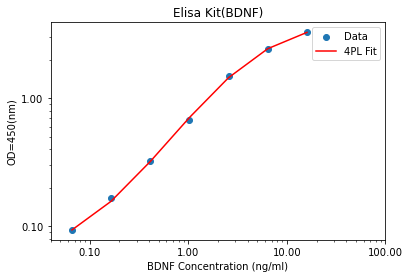

In [241]:
fig, ax = plt.subplots()
#ax.plot(x,y)

# Set the x-axis scale to 0.01, 0.1, 1, 10, and 100
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10, 100])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim([0.04, 100])


# Set the y-axis scale to 0.01, 0.1, 1, and 10
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 1, 10])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
#ax.set_ylim([0.05, 10])

plt.scatter(x,y,label='Data')
plt.plot(x, logistic_4(x, *ET_popt), 'r', label="4PL Fit")
plt.title('Elisa Kit(BDNF)')
plt.xlabel('BDNF Concentration (ng/ml)')
plt.ylabel('OD=450(nm)')
plt.legend()
plt.show()

In [234]:
# Print the parameter values and R-squared value
A = ET_popt[0]
B = ET_popt[1]
C = ET_popt[2]
D = ET_popt[3]


print('A =', ET_popt[0])
print('B =', ET_popt[1])
print('C =', ET_popt[2])
print('D =', ET_popt[3])
print('R-squared =', R_sq_ET)

A = 0.05632774728943218
B = 1.1042737004785685
C = 4.5555858909596285
D = 4.081205214611354
R-squared = 0.9996527082264522


### Fit unknown sample OD values to the 4-parameter logistic (4PL) curve

In [224]:
data

,Subject,Unknown_Samples,Standard
0,S1_5,3.10015,3.28435
1,S2_5,3.48695,2.41760
2,S3_5,3.60655,1.48765
3,S4_5,2.84820,0.67420
4,S1_10,2.46180,0.32045
5,S2_10,3.18280,0.16510
6,S3_10,2.85510,0.09385
7,S4_10,2.77075,0.03475


In [225]:
logistic_4(data.iloc[0,1],A, B, C, D)

1.647408489489921

In [226]:
comp_values= {'Subj':data['Subject'],
    'concentrations(ng/ml)':[logistic_4(data.iloc[0,1],A, B, C, D),logistic_4(data.iloc[1,1],A, B, C, D),logistic_4(data.iloc[2,1],A, B, C, D),
          logistic_4(data.iloc[3,1],A, B, C, D),logistic_4(data.iloc[4,1],A, B, C, D),logistic_4(data.iloc[5,1],A, B, C, D),
          logistic_4(data.iloc[6,1],A, B, C, D),logistic_4(data.iloc[7,1],A, B, C, D)]}
df_unsamp = pd.DataFrame(comp_values)
df_unsamp

,Subj,concentrations(ng/ml)
0,S1_5,1.647408
1,S2_5,1.773867
2,S3_5,1.810631
3,S4_5,1.558292
4,S1_10,1.410064
5,S2_10,1.675445
6,S3_10,1.560808
7,S4_10,1.529742


In [282]:
samples

,samples,Run_1,Run_2,SD,CV(%),avg_samples
0,Vi,3.09495,3.33145,0.167231,5.204493,3.21320
1,Si,2.99175,2.95395,0.026729,0.899091,2.97285
2,Zi,2.67165,2.56045,0.078630,3.005687,2.61605
3,Ci,2.76035,3.01775,0.182009,6.299970,2.88905
4,Cs,3.00285,3.11375,0.078418,2.564109,3.05830
5,Ai,2.75305,2.54035,0.150402,5.682609,2.64670
6,As,2.54115,2.64005,0.069933,2.699485,2.59060


### Computed values

In [315]:
A, B , C, D = ET_popt
comp_values= {'samples':['Vi','Si','Zi','Ci','Cs','Ai','As'],
    'OD':[logistic_4(samples.iloc[0,5],A, B, C, D),logistic_4(samples.iloc[1,5],A, B, C, D),logistic_4(samples.iloc[2,5],A, B, C, D),
          logistic_4(samples.iloc[3,5],A, B, C, D),logistic_4(samples.iloc[4,5],A, B, C, D),logistic_4(samples.iloc[5,5],A, B, C, D),
          logistic_4(samples.iloc[6,5],A, B, C, D)]}
df_comp = pd.DataFrame(comp_values)
df_comp['OD']= df_comp['OD']*10
df_comp

,samples,OD
0,Vi,237.562427
1,Si,196.758735
2,Zi,144.548300
3,Ci,183.613702
4,Cs,210.733870
5,Ai,148.652794
6,As,141.193331


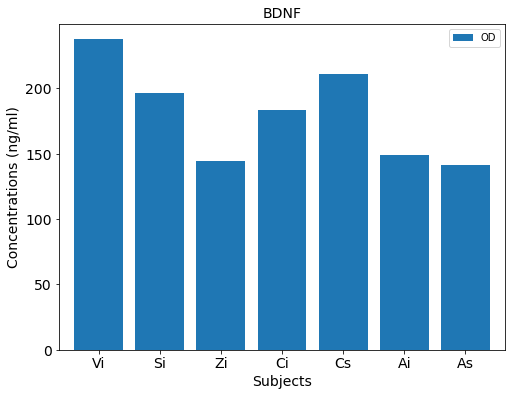

In [332]:
ax = df_comp.plot.bar(x='samples',y='OD',rot=0,width=0.8,figsize=(8,6))
plt.title('BDNF',fontsize=14)
plt.xlabel('Subjects',fontsize=14)
plt.ylabel('Concentrations (ng/ml)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### Conclusion
In healthy subjects, BDNF levels range from 12.2 ± 2.4 [mean ± standard deviation (SD)] to 64.1 ± 13.1 ng/mL. Unfortunately, our analysis revealed that the BDNF level from subjects are ten times higher than the published paper. We still need to do more experiments to get validated results.